# Bitcoin Price Prediction using HMM, LSTM, ARIMA, and RNN

   In this notebook, we will predict Bitcoin (BTC-USD) prices using various methods including Hidden Markov Model (HMM), Long Short-Term Memory (LSTM), AutoRegressive Integrated Moving Average (ARIMA), and Recurrent Neural Network (RNN). We will compare the performance of these models using various error metrics.

In [ ]:
!pip install hmmlearn
!pip install yfinance
!pip install statsmodels
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 34.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.4/118.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 130.6 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.18.1-cp311-cp311-linux_x86_64.whl size=886610 sha256=946ee630e67a15915051e832c2bf288a9cc1234318d4c50c502562fa3b2ad9b9
  Stored in directory: /root/.cache/pip/wheels/25/cb/79/a133a0d1d75f318a96614ed7fb97bdf2f35a7b6c4d4e426e3f
Successfully built peewee
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 17.6 MB/s eta 0:00:00
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import necessary libraries for data manipulation, model building, and evaluation
%matplotlib inline
from hmmlearn import hmm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math
import scipy.stats as stats
import statsmodels.api as sm
import gdown
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## Load and Prepare Data

In this section, we load the BTC-USD data and preprocess it for modeling.

In [ ]:
# Load BTC-USD data
df_btc = pd.read_csv('/content/layer-1-btc.csv')
data = df_btc[['Date', 'Open', 'High', 'Low', 'Close']]
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Use the data directly (daily frequency, no resampling needed)
obs = data.reset_index()
print(obs)

# Split data for training (first 80% of data, approximately)
train_size = int(len(obs) * 0.8)
data = obs[:train_size]
print(data)

<ipython-input-3-2623704245>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


           Date           Open           High            Low          Close
0    2014-09-17     465.864014     468.174011     452.421997     457.334015
1    2014-09-18     456.859985     456.859985     413.104004     424.440002
2    2014-09-19     424.102997     427.834991     384.532013     394.795990
3    2014-09-20     394.673004     423.295990     389.882996     408.903992
4    2014-09-21     408.084991     412.425995     393.181000     398.821014
...         ...            ...            ...            ...            ...
3918 2025-06-09  105793.023438  110561.421875  105400.234375  110294.101562
3919 2025-06-10  110295.687500  110380.125000  108367.710938  110257.234375
3920 2025-06-11  110261.796875  110384.218750  108086.328125  108686.625000
3921 2025-06-12  108685.914062  108780.695312  105785.687500  105929.054688
3922 2025-06-14  106109.468750  106109.468750  105938.718750  105938.718750

[3923 rows x 5 columns]
           Date          Open          High           Low      

## Hidden Markov Model (HMM)

We will implement the HMM to predict future Bitcoin prices.

In [ ]:
# Prepare data for HMM
data_hmm = data[data.columns[1:5]]
obs_hmm = obs[obs.columns[1:5]]
# Calculate number of rows and set training window
T = data_hmm.shape[0]
print("T = ", T)
# Define the size of the training window
d = int(T * 0.2)  # Predict 20% of the data
D = 500  # Look-back window for HMM training
hmm_price = []
temp_T = T
first_time = True
# Sliding window approach to predict future prices
while T < temp_T + d:
    # Train HMM on data from T-D+1 to T
    train_data = obs_hmm.iloc[max(0, T-D):T]
    train_data = train_data.dropna()
    # Set the random seed
    np.random.seed(123)
    if first_time:
        first_time = False
        model = hmm.GaussianHMM(n_components=5)
    else:
        old_model = model
        model = hmm.GaussianHMM(n_components=5, init_params="c")
        model.startprob_ = old_model.startprob_
        model.transmat_ = old_model.transmat_
        model.means_ = old_model.means_
    model.fit(train_data)
    # Calculate original likelihood
    original_likelihood = model.score(train_data)
    # Loop to find new likelihood
    t = T
    min_diff = float('inf')
    min_t = T
    min_likelihood = original_likelihood
    while t - D > 0:
        t = t - 1
        train_data = obs_hmm.iloc[t-D:t]
        new_likelihood = model.score(train_data)
        if abs(new_likelihood - original_likelihood) < min_diff:
            min_diff = abs(new_likelihood - original_likelihood)
            min_t = t
            min_likelihood = new_likelihood
    # Calculate the predicted close price
    close_price = obs_hmm['Close'][T-1] + ((obs_hmm['Close'][min_t + 1] - obs_hmm['Close'][min_t]) * np.sign(original_likelihood - min_likelihood))
    hmm_price.append(close_price)
    T = T + 1
# Print the calculated prices
print("HMM Prices: ")
print(hmm_price)

T =  3138
HMM Prices: 
[np.float64(27276.91015625), np.float64(27817.5), np.float64(27591.384765625), np.float64(27525.33984375), np.float64(27459.294921875), np.float64(28422.701171875), np.float64(29204.958984375), np.float64(29340.26171875), np.float64(29248.48828125), np.float64(29268.806640625), np.float64(28091.568359375), np.float64(28680.537109375), np.float64(29006.30859375), np.float64(28847.7109375), np.float64(29534.384765625), np.float64(28904.623046875), np.float64(28454.978515625), np.float64(27694.2734375), np.float64(27658.775390625), np.float64(27621.755859375), np.float64(27000.7890625), np.float64(26804.990234375), np.float64(26784.078125), np.float64(26930.638671875), np.float64(27192.693359375), np.float64(27036.650390625), np.float64(27398.802734375), np.float64(26832.208984375), np.float64(26890.12890625), np.float64(27129.5859375), np.float64(27505.345703125), np.float64(26993.283203125), np.float64(26611.8203125), np.float64(26334.818359375), np.float64(27225.

In [ ]:
# Plot the predicted and observed prices
close = []
truncated_obs = obs.iloc[T-d:T]

for i in truncated_obs['Close']:
  close.append(i)

In [ ]:
hmm_price_df = pd.DataFrame(hmm_price, columns=['HMM_Predicted_Close'])

hmm_price_df.to_csv('hmm_btc_predictions.csv', index=False)

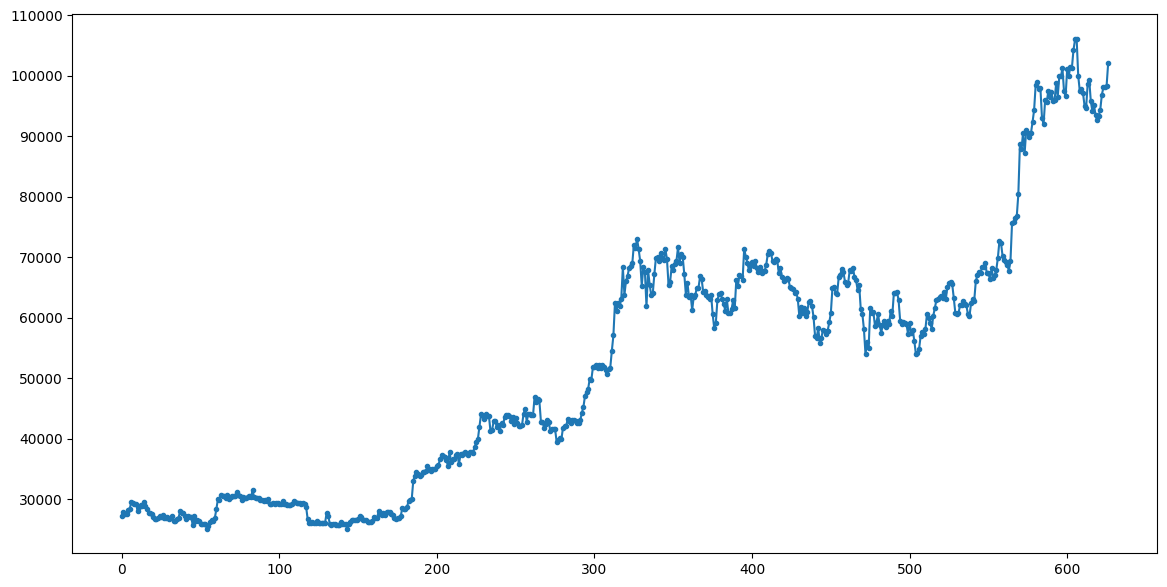

In [ ]:
plt.figure(figsize=(14, 7))

# Plot actual prices for the corresponding period
plt.plot(close, marker='.', label='Observed Price')

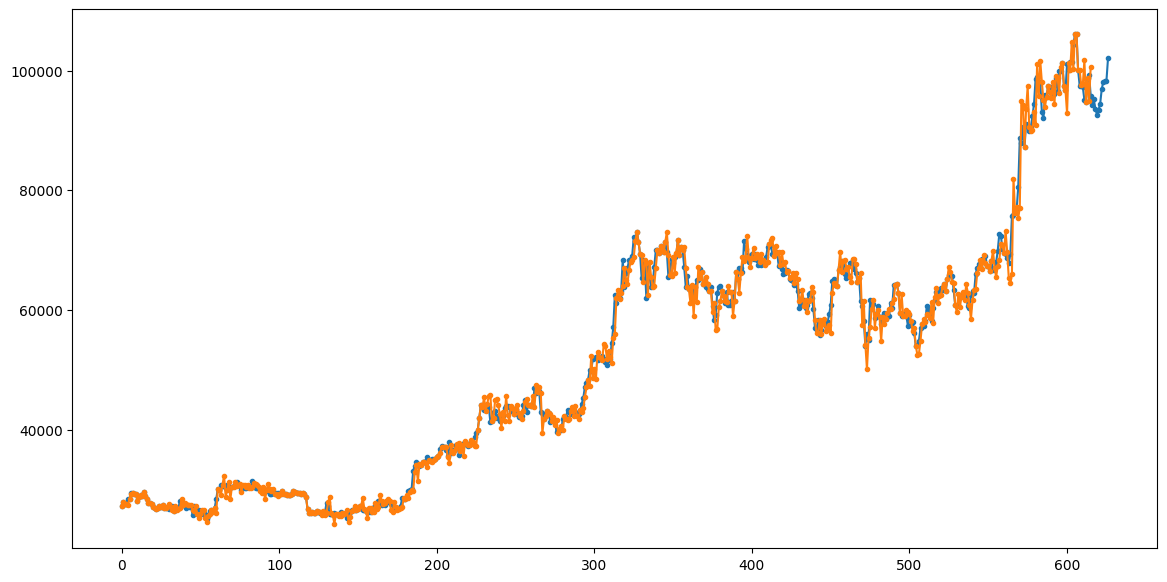

In [ ]:
plt.figure(figsize=(14, 7))

# Plot actual prices for the corresponding period
plt.plot(close, marker='.', label='Observed Price')
# Plot HMM predicted prices
plt.plot(hmm_price, marker='.', label='HMM Predicted Price')

In [ ]:
print(len(hmm_price))
print(len(close))

616
627


## HMM (Extend)

In [ ]:
import os

In [ ]:
# Prepare data for HMM
data_hmm = data[data.columns[1:5]]
obs_hmm = obs[obs.columns[1:5]]
T = data_hmm.shape[0]
d = int(T * 0.2)  # Predict 20% of the data
D = 500  # Look-back window for HMM training

In [ ]:
# Check if HMM predictions already exist
HMM_FILE = '/content/hmm_btc_predictions.csv'
RUN_HMM = not os.path.exists(HMM_FILE)  # Only run HMM if file doesn't exist

In [ ]:
if RUN_HMM:
    print("Running HMM model (this will take ~40 minutes)...")
    hmm_price = []
    temp_T = T
    first_time = True

    # Sliding window approach to predict future prices
    while T < temp_T + d:
        # Train HMM on data from T-D+1 to T
        train_data = obs_hmm.iloc[max(0, T-D):T]
        train_data = train_data.dropna()
        # Set the random seed
        np.random.seed(123)
        if first_time:
            first_time = False
            model = hmm.GaussianHMM(n_components=5)
        else:
            old_model = model
            model = hmm.GaussianHMM(n_components=5, init_params="c")
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_
        model.fit(train_data)
        # Calculate original likelihood
        original_likelihood = model.score(train_data)
        # Loop to find new likelihood
        t = T
        min_diff = float('inf')
        min_t = T
        min_likelihood = original_likelihood
        while t - D > 0:
            t = t - 1
            train_data = obs_hmm.iloc[t-D:t]
            new_likelihood = model.score(train_data)
            if abs(new_likelihood - original_likelihood) < min_diff:
                min_diff = abs(new_likelihood - original_likelihood)
                min_t = t
                min_likelihood = new_likelihood
        # Calculate the predicted close price
        close_price = obs_hmm['Close'][T-1] + ((obs_hmm['Close'][min_t + 1] - obs_hmm['Close'][min_t]) * np.sign(original_likelihood - min_likelihood))
        hmm_price.append(close_price)
        T = T + 1

    # Save HMM predictions
    hmm_price_df = pd.DataFrame(hmm_price, columns=['HMM_Predicted_Close'])
    hmm_price_df.to_csv(HMM_FILE, index=False)
    print("HMM model completed and saved!")
else:
    print("Loading existing HMM predictions...")
    hmm_price_df = pd.read_csv(HMM_FILE)
    hmm_price = hmm_price_df['HMM_Predicted_Close'].tolist()
    print(f"Loaded {len(hmm_price)} HMM predictions")

Loading existing HMM predictions...
Loaded 627 HMM predictions


Length of HMM predictions: 627
Length of observed prices: 627
HMM Prices (first 10):
[27276.91015625, 27817.5, 27591.384765625, 27525.33984375, 27459.294921875, 28422.701171875, 29204.958984375, 29340.26171875, 29248.48828125, 29268.806640625]


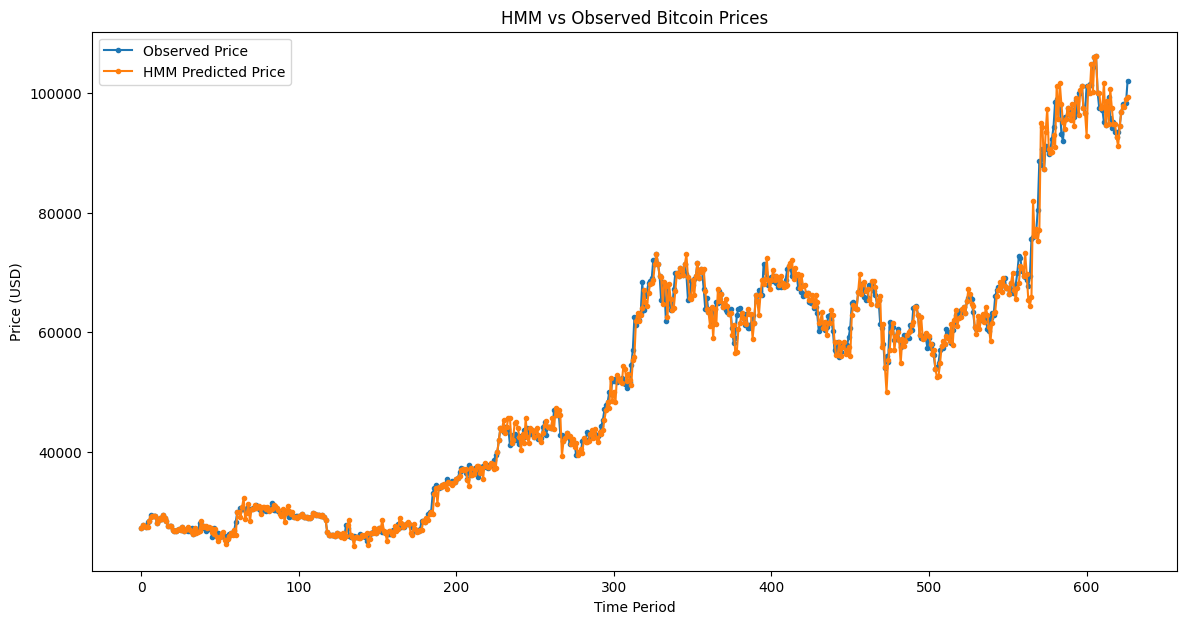

In [ ]:
# Reset T to original value for consistency
T = data_hmm.shape[0]

# Prepare the close prices for comparison (this is the 'close' variable you need)
truncated_obs = obs.iloc[T:T+d]  # Get the actual observed prices for the prediction period
close = truncated_obs['Close'].tolist()

print(f"Length of HMM predictions: {len(hmm_price)}")
print(f"Length of observed prices: {len(close)}")
print("HMM Prices (first 10):")
print(hmm_price[:10])

# Plot the predicted and observed prices
plt.figure(figsize=(14, 7))
# Plot actual prices for the corresponding period
plt.plot(close, marker='.', label='Observed Price')
# Plot HMM predicted prices
plt.plot(hmm_price, marker='.', label='HMM Predicted Price')
plt.legend()
plt.title('HMM vs Observed Bitcoin Prices')
plt.xlabel('Time Period')
plt.ylabel('Price (USD)')
plt.show()

## LSTM Model

In this section, we train an LSTM model to predict future Bitcoin prices.

In [ ]:
# LSTM Model
# In this section, we train an LSTM model to predict future Bitcoin prices.

# Scaling the data to the range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(obs['Close'].values.reshape(-1, 1))

# Prepare data for LSTM model (using the first D periods)
def prepare_data(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Use training data size for time_step calculation
time_step = train_size - D  # Same as original: obs.shape[0] - D

# Initialize an empty list to store the predictions
lstm_predictions = []

# Use scaled data up to training size for initial training
scaled_train_data = scaled_data[:train_size]

# Initial training on the training data
X_train, y_train = prepare_data(scaled_train_data, D)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Time step: {time_step}")
print(f"Will predict {d} periods")

# Build and train the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(D, 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

print("Training initial LSTM model...")
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Initialize with training data for predictions
current_scaled_data = scaled_data[:train_size].copy()

# Iteratively predict the next d periods and retrain the model
for i in range(d):  # Predict the next d periods
    print(f"Predicting period {i+1}/{d}")

    # Use the last D periods for prediction
    X_input = current_scaled_data[-D:]
    X_input = X_input.reshape(1, D, 1)

    # Make prediction
    pred = model_lstm.predict(X_input, verbose=0)
    lstm_predictions.append(pred[0, 0])

    # Add the predicted data to the current dataset
    current_scaled_data = np.append(current_scaled_data, pred).reshape(-1, 1)

    # Re-prepare the training data including the new data
    X_train_new, y_train_new = prepare_data(current_scaled_data, D)
    X_train_new = X_train_new.reshape(X_train_new.shape[0], X_train_new.shape[1], 1)

    # Retrain the LSTM model with the updated data (fewer epochs for efficiency)
    model_lstm.fit(X_train_new, y_train_new, epochs=5, batch_size=32, verbose=0)

# Inverse transform the predictions to the original scale
lstm_predictions = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1))

# Print LSTM predictions
print(f"LSTM predictions shape: {lstm_predictions.shape}")
print("LSTM Prices (first 10):")
print(lstm_predictions[:10].flatten())


X_train shape: (2638, 500, 1)
y_train shape: (2638,)
Time step: 2638
Will predict 627 periods


I0000 00:00:1749899652.352262    3411 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20974 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training initial LSTM model...
Epoch 1/10


I0000 00:00:1749899654.865670    5206 cuda_dnn.cc:529] Loaded cuDNN version 90701


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0113
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.5747e-04
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.4187e-04
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.9156e-04
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.4902e-04
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.9085e-04
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.3656e-04
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.9017e-04
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.0398e-04
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.2987e-04
Predicting period 1/627
Predicting period 2/627
Predicting period 3/627
Predicting period 4/627
Predicting period 5/627
Predicting period 6/627
Predicting period 7/627
Predicting period 8/627
Predicting period 9/627
Predicting period 10/627
Predicting period 11/627
Predicting period 12/627
Predicting period 13/62

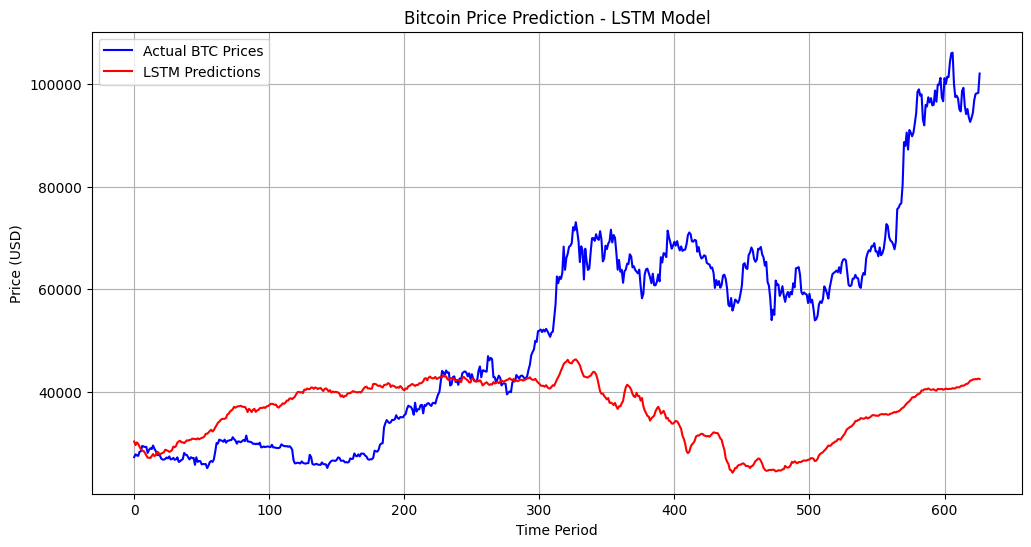

In [ ]:
# Plot LSTM predictions vs actual prices
plt.figure(figsize=(12, 6))
plt.plot(range(len(close)), close, label='Actual BTC Prices', color='blue')
plt.plot(range(len(lstm_predictions)), lstm_predictions.flatten(), label='LSTM Predictions', color='red')
plt.title('Bitcoin Price Prediction - LSTM Model')
plt.xlabel('Time Period')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Compare lengths
print(f"Length of LSTM predictions: {len(lstm_predictions)}")
print(f"Length of actual prices: {len(close)}")

Length of LSTM predictions: 627
Length of actual prices: 627


In [ ]:
# Flatten the LSTM predictions for easier handling
lstm_predictions_flat = lstm_predictions.flatten()

# Save LSTM predictions
lstm_price_df = pd.DataFrame(lstm_predictions_flat, columns=['LSTM_Predicted_Close'])
lstm_price_df.to_csv('lstm_btc_predictions.csv', index=False)


## LSTM Extend

In [ ]:
# Load LSTM predictions
LSTM_FILE = '/content/lstm_btc_predictions.csv'
lstm_price_df = pd.read_csv(LSTM_FILE)
lstm_predictions_flat = lstm_price_df['LSTM_Predicted_Close'].tolist()
print(f"Loaded {len(lstm_predictions_flat)} LSTM predictions")

Loaded 627 LSTM predictions


## Visualization

In this section, we plot the predicted prices from all models against the actual prices.

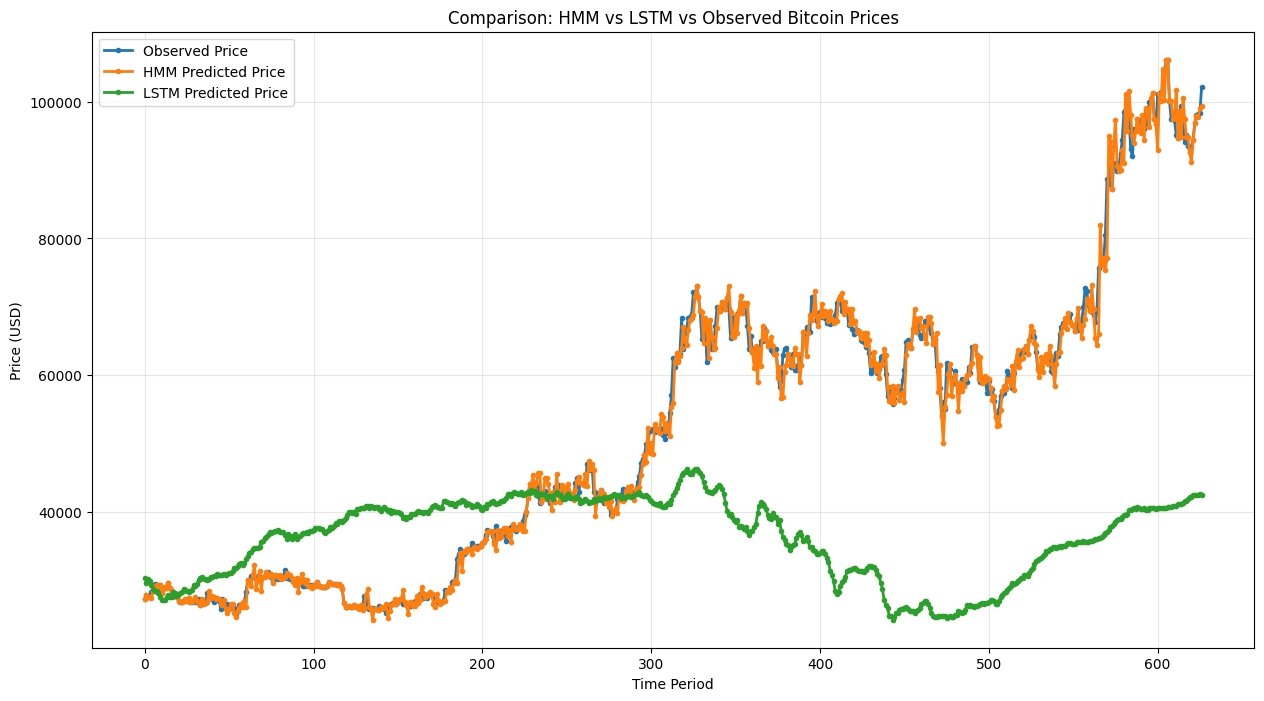

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(close, marker='.', label='Observed Price', linewidth=2)
plt.plot(hmm_price, marker='.', label='HMM Predicted Price', linewidth=2)
plt.plot(lstm_predictions_flat, marker='.', label='LSTM Predicted Price', linewidth=2)
plt.legend()
plt.title('Comparison: HMM vs LSTM vs Observed Bitcoin Prices')
plt.xlabel('Time Period')
plt.ylabel('Price (USD)')
plt.grid(True, alpha=0.3)
plt.show()

## Model Comparison and Efficiency Calculation

In this section, we calculate various error metrics for HMM and LSTM models and determine the efficiency of HMM compared to LSTM for Bitcoin price prediction.


In [ ]:
# Convert lists to numpy arrays
close = np.array(close)
hmm_price = np.array(hmm_price)
lstm_predictions = np.array(lstm_predictions_flat)

print("Original lengths:")
print(f"Actual prices: {len(close)}")
print(f"HMM predictions: {len(hmm_price)}")
print(f"LSTM predictions: {len(lstm_predictions)}")

Original lengths:
Actual prices: 627
HMM predictions: 627
LSTM predictions: 627


In [ ]:
# Ensure all are trimmed to the same length
min_length = min(len(close), len(hmm_price), len(lstm_predictions))
print(f"Minimum length for comparison: {min_length}")

Minimum length for comparison: 627


In [ ]:
close = close[:min_length]
hmm_price = hmm_price[:min_length]
lstm_predictions = lstm_predictions[:min_length]

print(f"After trimming - All arrays length: {len(close)}")

After trimming - All arrays length: 627


#### 1. Absolute Percentage Error (APE)

In [ ]:
def ape(real_, pred_):
    APE = 0
    sum_val = 0
    N = len(real_)
    # Calculate the sum of absolute differences between real and predicted values
    for i in range(1, N):
        sum_val += (np.abs(real_[i] - pred_[i])) / N

    # Calculate APE as a ratio of the sum to the mean of real values
    APE = sum_val / (np.mean(real_))

    return APE

ape_hmm = ape(close, hmm_price)
ape_lstm = ape(close, lstm_predictions)

#### 2. Average Absolute Error (AAE)

In [ ]:
def aae(real_, pred_):
    AAE = 0
    sum_val = 0
    N = len(real_)
    for i in range(1, N):
        sum_val += (np.abs(real_[i] - pred_[i])) / N
    AAE = sum_val
    return AAE

aae_hmm = aae(close, hmm_price)
aae_lstm = aae(close, lstm_predictions)

#### 3. Average Relative Percentage Error (ARPE)

In [ ]:
def arpe(real_, pred_):
    sum_val = 0
    N = len(real_)
    for i in range(1, N):
        sum_val += (np.abs(real_[i] - pred_[i])) / N
    ARPE = sum_val / N
    return ARPE

arpe_hmm = arpe(close, hmm_price)
arpe_lstm = arpe(close, lstm_predictions)

#### 4. Root Mean Squared Error (RMSE)

In [ ]:
def rmse(real_, pred_):
    sum_val = 0
    N = len(real_)
    for i in range(1, N):
        sum_val += (np.square(real_[i] - pred_[i])) / N
    RMSE = np.sqrt(sum_val)
    return RMSE

rmse_hmm = rmse(close, hmm_price)
rmse_lstm = rmse(close, lstm_predictions)

#### 5. Mean Absolute Percentage Error (MAPE) - Additional metric

In [ ]:
def mape(real_, pred_):
    return np.mean(np.abs((real_ - pred_) / real_)) * 100

mape_hmm = mape(close, hmm_price)
mape_lstm = mape(close, lstm_predictions)

#### 6. Efficiency Calculation (HMM vs LSTM)

In [ ]:
def efficiency(hmm_metric, other_metric):
    return 1 - (hmm_metric / other_metric)

eff_lstm = {
    'APE': efficiency(ape_hmm, ape_lstm),
    'AAE': efficiency(aae_hmm, aae_lstm),
    'ARPE': efficiency(arpe_hmm, arpe_lstm),
    'RMSE': efficiency(rmse_hmm, rmse_lstm),
    'MAPE': efficiency(mape_hmm, mape_lstm)
}

In [ ]:
print("\n📊 ERROR METRICS COMPARISON:")
print("-" * 40)
print(f"{'Metric':<15} {'HMM':<15} {'LSTM':<15}")
print("-" * 40)
print(f"{'APE':<15} {ape_hmm:<15.6f} {ape_lstm:<15.6f}")
print(f"{'AAE':<15} {aae_hmm:<15.2f} {aae_lstm:<15.2f}")
print(f"{'ARPE':<15} {arpe_hmm:<15.6f} {arpe_lstm:<15.6f}")
print(f"{'RMSE':<15} {rmse_hmm:<15.2f} {rmse_lstm:<15.2f}")
print(f"{'MAPE (%)':<15} {mape_hmm:<15.2f} {mape_lstm:<15.2f}")



📊 ERROR METRICS COMPARISON:
----------------------------------------
Metric          HMM             LSTM           
----------------------------------------
APE             0.021707        0.404073       
AAE             1129.45         21024.81       
ARPE            1.801357        33.532394      
RMSE            1848.03         27017.80       
MAPE (%)        2.05            35.54          


In [ ]:
print("\n🎯 HMM vs LSTM EFFICIENCY:")
print("-" * 40)
for metric, efficiency_val in eff_lstm.items():
    if isinstance(efficiency_val, np.ndarray):
        efficiency_val = efficiency_val[0]

    if efficiency_val > 0:
        status = f"✅ HMM is {efficiency_val*100:.2f}% more efficient"
    else:
        status = f"❌ LSTM is {abs(efficiency_val)*100:.2f}% more efficient"

    print(f"{metric:<8}: {efficiency_val:<12.6f} - {status}")



🎯 HMM vs LSTM EFFICIENCY:
----------------------------------------
APE     : 0.946280     - ✅ HMM is 94.63% more efficient
AAE     : 0.946280     - ✅ HMM is 94.63% more efficient
ARPE    : 0.946280     - ✅ HMM is 94.63% more efficient
RMSE    : 0.931600     - ✅ HMM is 93.16% more efficient
MAPE    : 0.942221     - ✅ HMM is 94.22% more efficient


In [ ]:
# Determine overall winner
metrics_won_by_hmm = sum(1 for val in eff_lstm.values() if
                        (val[0] if isinstance(val, np.ndarray) else val) > 0)
total_metrics = len(eff_lstm)

print(f"\n🏆 OVERALL PERFORMANCE:")
print("-" * 40)
print(f"HMM wins in: {metrics_won_by_hmm}/{total_metrics} metrics")
print(f"LSTM wins in: {total_metrics - metrics_won_by_hmm}/{total_metrics} metrics")


🏆 OVERALL PERFORMANCE:
----------------------------------------
HMM wins in: 5/5 metrics
LSTM wins in: 0/5 metrics


#### Create comparison visualization

In [ ]:
plt.figure(figsize=(15, 8))

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

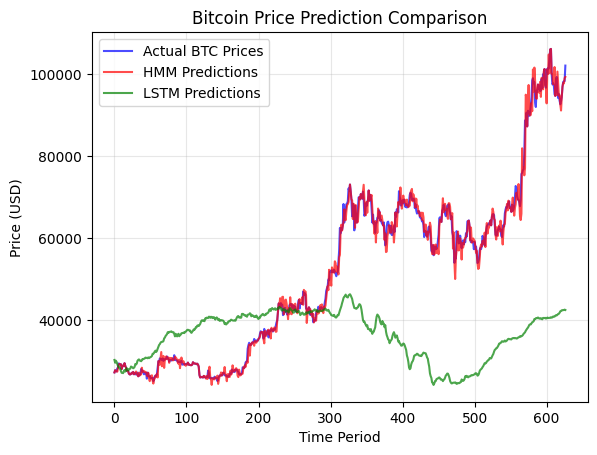

In [ ]:
# Plot 1: Actual vs Predictions
plt.plot(range(len(close)), close, label='Actual BTC Prices', color='blue', alpha=0.7)
plt.plot(range(len(hmm_price)), hmm_price, label='HMM Predictions', color='red', alpha=0.7)
plt.plot(range(len(lstm_predictions)), lstm_predictions, label='LSTM Predictions', color='green', alpha=0.7)
plt.title('Bitcoin Price Prediction Comparison')
plt.xlabel('Time Period')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

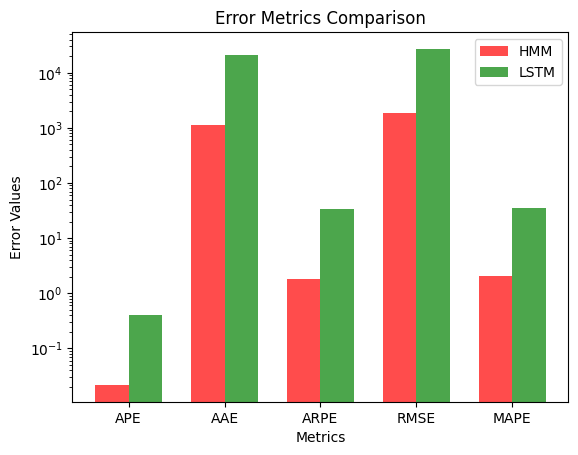

In [ ]:
# Plot 2: Error Comparison
metrics = ['APE', 'AAE', 'ARPE', 'RMSE', 'MAPE']
hmm_values = [ape_hmm, aae_hmm, arpe_hmm, rmse_hmm, mape_hmm]
lstm_values = [ape_lstm, aae_lstm, arpe_lstm, rmse_lstm, mape_lstm]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, hmm_values, width, label='HMM', color='red', alpha=0.7)
plt.bar(x + width/2, lstm_values, width, label='LSTM', color='green', alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Error Values')
plt.title('Error Metrics Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.yscale('log')  # Log scale due to different magnitudes


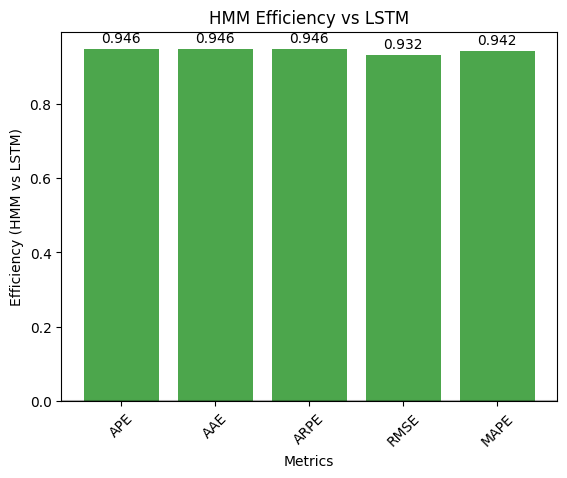

In [ ]:
# Plot 3: Efficiency Visualization
efficiency_values = [val[0] if isinstance(val, np.ndarray) else val for val in eff_lstm.values()]
colors = ['green' if val > 0 else 'red' for val in efficiency_values]
bars = plt.bar(metrics, efficiency_values, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Metrics')
plt.ylabel('Efficiency (HMM vs LSTM)')
plt.title('HMM Efficiency vs LSTM')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, val in zip(bars, efficiency_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.03),
             f'{val:.3f}', ha='center', va='bottom' if height >= 0 else 'top')


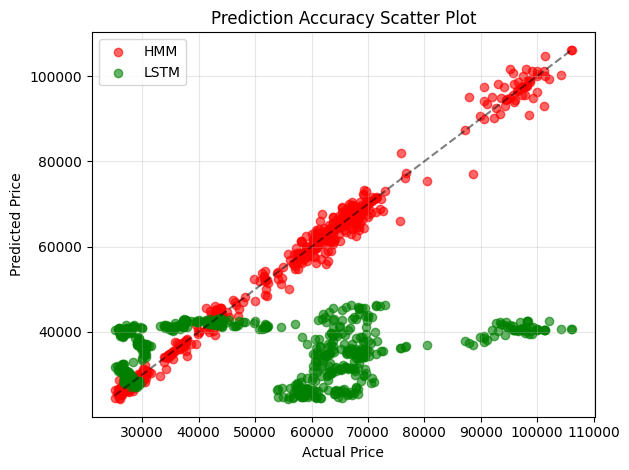

In [ ]:
# Plot 4: Prediction Accuracy Scatter
plt.scatter(close, hmm_price, alpha=0.6, label='HMM', color='red')
plt.scatter(close, lstm_predictions, alpha=0.6, label='LSTM', color='green')
plt.plot([close.min(), close.max()], [close.min(), close.max()], 'k--', alpha=0.5)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Prediction Accuracy Scatter Plot')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()